In [3]:
!pip -q install kaggle torch torchvision pandas scikit-learn tqdm matplotlib


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aabhasgurung","key":"8ea4e162f39b2f0c9b34750da5c3e6f0"}'}

# New section

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -la ~/.kaggle


total 16
drwxr-xr-x 2 root root 4096 Jan 28 11:26 .
drwx------ 1 root root 4096 Jan 28 11:26 ..
-rw------- 1 root root   68 Jan 28 11:26 kaggle.json


In [6]:
!kaggle datasets download -d ziya07/multimodal-e-commerce-dataset -p /content --force
!unzip -q /content/multimodal-e-commerce-dataset.zip -d /content/dataset
!ls -lah /content/dataset | head -n 50


Dataset URL: https://www.kaggle.com/datasets/ziya07/multimodal-e-commerce-dataset
License(s): CC0-1.0
 99% 2.38G/2.41G [00:16<00:00, 86.1MB/s]
100% 2.41G/2.41G [00:17<00:00, 151MB/s] 
total 61M
drwxr-xr-x 3 root root 4.0K Jan 28 11:27 .
drwxr-xr-x 1 root root 4.0K Jan 28 11:27 ..
drwxr-xr-x 3 root root 4.0K Jan 28 11:27 images
-rw-r--r-- 1 root root 8.5M Aug  9 10:10 X_test_update.csv
-rw-r--r-- 1 root root  52M Aug  9 10:10 X_train_update.csv
-rw-r--r-- 1 root root 886K Aug  9 10:10 Y_train_CVw08PX.csv


In [7]:
!ls -lah /content


total 2.5G
drwxr-xr-x 1 root root 4.0K Jan 28 11:27 .
drwxr-xr-x 1 root root 4.0K Jan 28 11:26 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Jan 28 11:27 dataset
-rw-r--r-- 1 root root   68 Jan 28 11:26 kaggle.json
-rw-r--r-- 1 root root 2.5G Aug  9 10:13 multimodal-e-commerce-dataset.zip
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data


In [8]:
!ls -lah /content/dataset | head -n 50


total 61M
drwxr-xr-x 3 root root 4.0K Jan 28 11:27 .
drwxr-xr-x 1 root root 4.0K Jan 28 11:27 ..
drwxr-xr-x 3 root root 4.0K Jan 28 11:27 images
-rw-r--r-- 1 root root 8.5M Aug  9 10:10 X_test_update.csv
-rw-r--r-- 1 root root  52M Aug  9 10:10 X_train_update.csv
-rw-r--r-- 1 root root 886K Aug  9 10:10 Y_train_CVw08PX.csv


In [9]:
import pandas as pd

x_train_path = "/content/dataset/X_train_update.csv"
y_train_path = "/content/dataset/Y_train_CVw08PX.csv"

x_train = pd.read_csv(x_train_path)
y_train = pd.read_csv(y_train_path)

x_train = x_train.rename(columns={"Unnamed: 0": "idx"})
y_train = y_train.rename(columns={"Unnamed: 0": "idx"})

print("X_train columns:", list(x_train.columns))
print("Y_train columns:", list(y_train.columns))

train_df = x_train.merge(y_train, on="idx", how="inner")

print("Merged train_df shape:", train_df.shape)
train_df.head(3)



X_train columns: ['idx', 'designation', 'description', 'productid', 'imageid']
Y_train columns: ['idx', 'prdtypecode']
Merged train_df shape: (84916, 6)


,idx,designation,description,productid,imageid,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50


In [10]:
import pandas as pd


train_df["designation"] = train_df["designation"].fillna("")
train_df["description"] = train_df["description"].fillna("")

train_df["text"] = (train_df["designation"].astype(str) + " " + train_df["description"].astype(str)).str.strip()

label_col = "prdtypecode"

train_df[["text", label_col, "imageid"]].head(5)


,text,prdtypecode,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,10,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,2280,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,50,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,1280,457047496
4,La Guerre Des Tuques Luc a des id&eacute;es de...,2705,1077757786


In [11]:
import os, glob, re
import pandas as pd

IMAGES_DIR = "/content/dataset/images"

all_imgs = glob.glob(os.path.join(IMAGES_DIR, "**", "*.*"), recursive=True)
print("Total image files:", len(all_imgs))
print("Sample filenames:")
for p in all_imgs[:20]:
    print(os.path.relpath(p, IMAGES_DIR))

token_to_path = {}
for p in all_imgs:
    base = os.path.splitext(os.path.basename(p))[0]
    tokens = re.findall(r"\d+", base)
    for tok in tokens:

        token_to_path.setdefault(tok.lstrip("0") or "0", p)

print("token_to_path size:", len(token_to_path))

candidates = ["imageid", "idx", "productid"]
for col in candidates:
    if col not in train_df.columns:
        continue
    mapped = train_df[col].astype(str).map(lambda x: token_to_path.get(x.lstrip("0") or "0"))
    missing = mapped.isna().sum()
    print(f"Mapping with {col}: missing {missing} / {len(train_df)}")

best_col = None
best_missing = 10**18
for col in candidates:
    if col not in train_df.columns:
        continue
    mapped = train_df[col].astype(str).map(lambda x: token_to_path.get(x.lstrip("0") or "0"))
    missing = mapped.isna().sum()
    if missing < best_missing:
        best_missing = missing
        best_col = col

print("Best column for image mapping:", best_col, "with missing:", best_missing)

train_df["image_path"] = train_df[best_col].astype(str).map(lambda x: token_to_path.get(x.lstrip("0") or "0"))

print("Final missing image_path:", train_df["image_path"].isna().sum(), "/", len(train_df))
train_df[["idx", "imageid", "productid", "image_path"]].head(10)


Total image files: 98728
Sample filenames:
images/image_test/image_1172791716_product_2920940632.jpg
images/image_test/image_1202115841_product_3252153251.jpg
images/image_test/image_894738452_product_142133531.jpg
images/image_test/image_1248849590_product_3817903723.jpg
images/image_test/image_966715446_product_253505692.jpg
images/image_test/image_1175654040_product_2949631483.jpg
images/image_test/image_1136092448_product_2140542468.jpg
images/image_test/image_1317195042_product_4210983491.jpg
images/image_test/image_1307450455_product_4171533427.jpg
images/image_test/image_1190252801_product_2887023744.jpg
images/image_test/image_1039431483_product_733742712.jpg
images/image_test/image_1061520464_product_567636627.jpg
images/image_test/image_1254339167_product_3861176334.jpg
images/image_test/image_1323957249_product_4232364983.jpg
images/image_test/image_1316644624_product_4200950003.jpg
images/image_test/image_1231223035_product_3646448539.jpg
images/image_test/image_1166174010_

,idx,imageid,productid,image_path
0,0,1263597046,3804725264,/content/dataset/images/images/image_train/ima...
1,1,1008141237,436067568,/content/dataset/images/images/image_train/ima...
2,2,938777978,201115110,/content/dataset/images/images/image_train/ima...
3,3,457047496,50418756,/content/dataset/images/images/image_train/ima...
4,4,1077757786,278535884,/content/dataset/images/images/image_train/ima...
5,5,393356830,5862738,/content/dataset/images/images/image_train/ima...
6,6,907794536,91920807,/content/dataset/images/images/image_train/ima...
7,7,999581347,344240059,/content/dataset/images/images/image_train/ima...
8,8,1325918866,4239126071,/content/dataset/images/images/image_train/ima...
9,9,1245644185,3793572222,/content/dataset/images/images/image_train/ima...


In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

label_col = "prdtypecode"

df = train_df[["image_path", "text", label_col]].copy()

labels = sorted(df[label_col].unique().tolist())
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

df["label_id"] = df[label_col].map(label2id)

print("Num classes:", len(label2id))
print(df[["image_path","text",label_col,"label_id"]].head(3))


Num classes: 27
                                          image_path  \
0  /content/dataset/images/images/image_train/ima...   
1  /content/dataset/images/images/image_train/ima...   
2  /content/dataset/images/images/image_train/ima...   

                                                text  prdtypecode  label_id  
0  Olivia: Personalisiertes Notizbuch / 150 Seite...           10         0  
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         2280        18  
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...           50         2  


In [13]:
train_df2, val_df2 = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label_id"]
)

print("Train:", train_df2.shape, "Val:", val_df2.shape)

train_df2.to_csv("/content/train_split.csv", index=False)
val_df2.to_csv("/content/val_split.csv", index=False)

print("Saved: /content/train_split.csv and /content/val_split.csv")


Train: (72178, 4) Val: (12738, 4)
Saved: /content/train_split.csv and /content/val_split.csv


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class EcomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64, tf=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tf = tf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image
        img = Image.open(row["image_path"]).convert("RGB")
        if self.tf:
            img = self.tf(img)

        # Text
        text = str(row["text"])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {
            "image": img,
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(int(row["label_id"]), dtype=torch.long),
        }
        return item

train_ds = EcomDataset(train_df2, tokenizer, max_len=64, tf=train_tf)
val_ds   = EcomDataset(val_df2, tokenizer, max_len=64, tf=val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

print("Dataset ready")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Dataset ready


In [15]:
batch = next(iter(train_loader))
for k, v in batch.items():
    print(k, v.shape, v.dtype)


image torch.Size([16, 3, 224, 224]) torch.float32
input_ids torch.Size([16, 64]) torch.int64
attention_mask torch.Size([16, 64]) torch.int64
label torch.Size([16]) torch.int64


In [16]:
import numpy as np

FAST_TRAIN = 10000
FAST_VAL = 2000

train_small = train_df2.sample(n=FAST_TRAIN, random_state=42)
val_small   = val_df2.sample(n=FAST_VAL, random_state=42)

train_ds = EcomDataset(train_small, tokenizer, max_len=64, tf=train_tf)
val_ds   = EcomDataset(val_small, tokenizer, max_len=64, tf=val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

print(len(train_ds), len(val_ds))


10000 2000


In [17]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

NUM_CLASSES = len(label2id)

class ImageOnlyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = m.fc.in_features
        m.fc = nn.Identity()  # remove classifier
        self.backbone = m
        self.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids=None, attention_mask=None):
        feats = self.backbone(image)
        return self.head(feats)


Device: cuda


In [18]:
import torch
import torch.nn as nn
from transformers import AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

NUM_CLASSES = len(label2id)

class TextOnlyModel(nn.Module):
    def __init__(self, num_classes, model_name="distilbert-base-uncased", dropout=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image=None, input_ids=None, attention_mask=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]  # DistilBERT "CLS-like" token
        return self.head(cls)






Device: cuda


In [19]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

NUM_CLASSES = len(label2id)

class MultiModalConcat(nn.Module):
    def __init__(self, num_classes, text_model="distilbert-base-uncased", dropout=0.2):
        super().__init__()

        # Image encoder (ResNet18)
        img = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        img_dim = img.fc.in_features
        img.fc = nn.Identity()
        self.img_encoder = img
        self.img_proj = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.ReLU()
        )

        # Text encoder (DistilBERT)
        self.txt_encoder = AutoModel.from_pretrained(text_model)
        txt_dim = self.txt_encoder.config.hidden_size
        self.txt_proj = nn.Sequential(
            nn.Linear(txt_dim, 256),
            nn.ReLU()
        )

        # Fusion head
        self.head = nn.Sequential(
            nn.Linear(256 + 256, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feats = self.img_encoder(image)
        img_feats = self.img_proj(img_feats)

        txt_out = self.txt_encoder(input_ids=input_ids, attention_mask=attention_mask)
        txt_feats = txt_out.last_hidden_state[:, 0]
        txt_feats = self.txt_proj(txt_feats)

        fused = torch.cat([img_feats, txt_feats], dim=1)
        return self.head(fused)



Device: cuda


In [20]:
from tqdm import tqdm
import torch

def train_one_epoch(model, loader, optimizer, criterion, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.train()
    total_loss = 0.0
    all_true, all_pred = [], []

    for batch in tqdm(loader, desc="train"):
        image = batch.get("image", None)
        input_ids = batch.get("input_ids", None)
        attention_mask = batch.get("attention_mask", None)
        labels = batch["label"].to(device)

        if image is not None: image = image.to(device)
        if input_ids is not None: input_ids = input_ids.to(device)
        if attention_mask is not None: attention_mask = attention_mask.to(device)

        optimizer.zero_grad()

        logits = model(
            image=image,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1).detach().cpu().tolist()
        all_pred.extend(preds)
        all_true.extend(labels.detach().cpu().tolist())

    # your metrics function must exist already; if not, tell me
    return total_loss / max(1, len(loader)), compute_metrics(all_true, all_pred)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    total_loss = 0.0
    all_true, all_pred = [], []

    for batch in tqdm(loader, desc="val"):
        image = batch.get("image", None)
        input_ids = batch.get("input_ids", None)
        attention_mask = batch.get("attention_mask", None)
        labels = batch["label"].to(device)

        if image is not None: image = image.to(device)
        if input_ids is not None: input_ids = input_ids.to(device)
        if attention_mask is not None: attention_mask = attention_mask.to(device)

        logits = model(
            image=image,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        loss = criterion(logits, labels)

        total_loss += loss.item()
        preds = logits.argmax(dim=1).detach().cpu().tolist()
        all_pred.extend(preds)
        all_true.extend(labels.detach().cpu().tolist())

    return total_loss / max(1, len(loader)), compute_metrics(all_true, all_pred)


In [21]:
import copy
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def fit_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=5,
    patience=2,
    monitor="f1_macro",
    ckpt_path="best_model.pt",
):
    best_score = -1.0
    best_state = None
    no_improve = 0
    history = []

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss, train_metrics = train_one_epoch(
            model, train_loader, optimizer, criterion
        )
        val_loss, val_metrics = eval_one_epoch(
            model, val_loader, criterion
        )

        score = val_metrics[monitor]

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            **{f"train_{k}": v for k, v in train_metrics.items()},
            "val_loss": val_loss,
            **{f"val_{k}": v for k, v in val_metrics.items()},
        })

        print(
            f"train_loss={train_loss:.4f} | "
            f"val_loss={val_loss:.4f} | "
            f"val_acc={val_metrics['accuracy']:.4f} | "
            f"val_f1_macro={val_metrics['f1_macro']:.4f}"
        )

        if score > best_score:
            best_score = score
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, ckpt_path)
            no_improve = 0
            print(f"Saved best model → {ckpt_path}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("⏹️ Early stopping triggered")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {"accuracy": acc, "precision_macro": p, "recall_macro": r, "f1_macro": f1}



In [22]:
mm_model = MultiModalConcat(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mm_model.parameters(), lr=2e-5, weight_decay=1e-2)

mm_model, mm_history = fit_model(
    model=mm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=5,
    patience=2,
    monitor="f1_macro",
    ckpt_path="best_multimodal.pt",
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/5


val: 100%|██████████| 125/125 [00:14<00:00,  8.87it/s]


train_loss=2.2730 | val_loss=1.4111 | val_acc=0.6165 | val_f1_macro=0.3958
Saved best model → best_multimodal.pt

Epoch 2/5


val: 100%|██████████| 125/125 [00:13<00:00,  9.01it/s]


train_loss=1.1659 | val_loss=0.9656 | val_acc=0.7225 | val_f1_macro=0.5780
Saved best model → best_multimodal.pt

Epoch 3/5


val: 100%|██████████| 125/125 [00:13<00:00,  9.22it/s]


train_loss=0.7319 | val_loss=0.8281 | val_acc=0.7680 | val_f1_macro=0.6960
Saved best model → best_multimodal.pt

Epoch 4/5


val: 100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


train_loss=0.4642 | val_loss=0.7724 | val_acc=0.7880 | val_f1_macro=0.7316
Saved best model → best_multimodal.pt

Epoch 5/5


val: 100%|██████████| 125/125 [00:15<00:00,  7.87it/s]


train_loss=0.2947 | val_loss=0.7345 | val_acc=0.8040 | val_f1_macro=0.7565
Saved best model → best_multimodal.pt


In [23]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

model = mm_model
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        image = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"].to(device)

        logits = model(image=image, input_ids=input_ids, attention_mask=attention_mask)

        preds = logits.argmax(dim=1)

        y_true.extend(label.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Metrics
acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

metrics = {
    "val_accuracy": float(acc),
    "val_precision_macro": float(p),
    "val_recall_macro": float(r),
    "val_f1_macro": float(f1),
    "model": "multimodal_concat"
}
print("Metrics:", metrics)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
os.makedirs("/content/results", exist_ok=True)

plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix (Multimodal Concat)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("/content/results/confusion_matrix_multimodal_concat.png", dpi=200)
plt.close()

print("Saved:", "/content/results/confusion_matrix_multimodal_concat.png")


report = classification_report(y_true, y_pred, digits=4, zero_division=0)
print("\nClassification Report (Val):\n")
print(report)

with open("/content/results/metrics_multimodal_concat.json", "w") as f:
    json.dump(metrics, f, indent=2)

with open("/content/results/classification_report_multimodal_concat.txt", "w") as f:
    f.write(report)

print("Saved:", "/content/results/metrics_multimodal_concat.json")
print("Saved:", "/content/results/classification_report_multimodal_concat.txt")


Metrics: {'val_accuracy': 0.804, 'val_precision_macro': 0.8004594569038617, 'val_recall_macro': 0.7493364844067378, 'val_f1_macro': 0.7564933396362193, 'model': 'multimodal_concat'}
Saved: /content/results/confusion_matrix_multimodal_concat.png

Classification Report (Val):

              precision    recall  f1-score   support

           0     0.7123    0.6753    0.6933        77
           1     0.6719    0.6719    0.6719        64
           2     0.6875    0.7097    0.6984        31
           3     0.9375    0.7500    0.8333        20
           4     0.7067    0.7910    0.7465        67
           5     0.9432    0.9540    0.9486        87
           6     1.0000    0.1053    0.1905        19
           7     0.7364    0.7297    0.7330       111
           8     0.5745    0.5000    0.5347        54
           9     0.9612    0.9466    0.9538       131
          10     0.9655    0.9655    0.9655        29
          11     0.8125    0.6842    0.7429        57
          12     0.70

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "accuracy": acc,
        "precision_macro": p,
        "recall_macro": r,
        "f1_macro": f1
    }


In [25]:
txt_model = TextOnlyModel(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(txt_model.parameters(), lr=2e-5, weight_decay=1e-2)

txt_model, txt_history = fit_model(
    model=txt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=3,
    patience=1,
    monitor="f1_macro",
    ckpt_path="best_text_only.pt",
)



Epoch 1/3


val: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]


train_loss=2.0142 | val_loss=1.2856 | val_acc=0.6365 | val_f1_macro=0.4768
Saved best model → best_text_only.pt

Epoch 2/3


val: 100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


train_loss=1.0344 | val_loss=0.9468 | val_acc=0.7365 | val_f1_macro=0.6685
Saved best model → best_text_only.pt

Epoch 3/3


val: 100%|██████████| 125/125 [00:13<00:00,  9.23it/s]


train_loss=0.6384 | val_loss=0.8740 | val_acc=0.7580 | val_f1_macro=0.7113
Saved best model → best_text_only.pt


In [26]:
img_model = ImageOnlyModel(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(img_model.parameters(), lr=2e-4, weight_decay=1e-2)

img_model, img_history = fit_model(
    model=img_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    epochs=3,
    patience=2,
    monitor="f1_macro",
    ckpt_path="best_image_only.pt",
)



Epoch 1/5


val: 100%|██████████| 125/125 [00:12<00:00,  9.71it/s]


train_loss=2.1520 | val_loss=1.9062 | val_acc=0.4630 | val_f1_macro=0.3504
Saved best model → best_image_only.pt

Epoch 2/5


val: 100%|██████████| 125/125 [00:13<00:00,  9.43it/s]


train_loss=1.7117 | val_loss=1.7519 | val_acc=0.4905 | val_f1_macro=0.3741
Saved best model → best_image_only.pt

Epoch 3/5


val: 100%|██████████| 125/125 [00:12<00:00,  9.71it/s]


train_loss=1.4548 | val_loss=1.7218 | val_acc=0.5150 | val_f1_macro=0.4347
Saved best model → best_image_only.pt

Epoch 4/5


val: 100%|██████████| 125/125 [00:12<00:00,  9.71it/s]


train_loss=1.2458 | val_loss=1.8099 | val_acc=0.4935 | val_f1_macro=0.4289

Epoch 5/5


val: 100%|██████████| 125/125 [00:13<00:00,  9.61it/s]


train_loss=1.0292 | val_loss=1.8857 | val_acc=0.5130 | val_f1_macro=0.4413
Saved best model → best_image_only.pt


In [27]:
model = img_model
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        image = batch.get("image", None)
        input_ids = batch.get("input_ids", None)
        attention_mask = batch.get("attention_mask", None)
        label = batch["label"].to(device)

        if image is not None: image = image.to(device)
        if input_ids is not None: input_ids = input_ids.to(device)
        if attention_mask is not None: attention_mask = attention_mask.to(device)

        logits = model(image=image, input_ids=input_ids, attention_mask=attention_mask)
        preds = logits.argmax(dim=1)

        y_true.extend(label.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())


In [28]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

os.makedirs("/content/results", exist_ok=True)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

metrics = {
    "val_accuracy": float(acc),
    "val_precision_macro": float(p),
    "val_recall_macro": float(r),
    "val_f1_macro": float(f1),
    "model": "image_only"
}
print("Metrics:", metrics)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix (Image-only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("/content/results/confusion_matrix_image_only.png", dpi=200)
plt.close()

report = classification_report(y_true, y_pred, digits=4, zero_division=0)

with open("/content/results/metrics_image_only.json", "w") as f:
    json.dump(metrics, f, indent=2)

with open("/content/results/classification_report_image_only.txt", "w") as f:
    f.write(report)

print("Saved image-only outputs ")


Metrics: {'val_accuracy': 0.513, 'val_precision_macro': 0.4975741725592825, 'val_recall_macro': 0.436240259109593, 'val_f1_macro': 0.4412540748728456, 'model': 'image_only'}
Saved image-only outputs 


In [29]:
model = txt_model
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        image = batch.get("image", None)
        input_ids = batch.get("input_ids", None)
        attention_mask = batch.get("attention_mask", None)
        label = batch["label"].to(device)

        if image is not None: image = image.to(device)
        if input_ids is not None: input_ids = input_ids.to(device)
        if attention_mask is not None: attention_mask = attention_mask.to(device)

        logits = model(image=image, input_ids=input_ids, attention_mask=attention_mask)
        preds = logits.argmax(dim=1)

        y_true.extend(label.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())




In [30]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

os.makedirs("/content/results", exist_ok=True)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

metrics = {
    "val_accuracy": float(acc),
    "val_precision_macro": float(p),
    "val_recall_macro": float(r),
    "val_f1_macro": float(f1),
    "model": "text_only"
}
print("Metrics:", metrics)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix (Text-only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("/content/results/confusion_matrix_text_only.png", dpi=200)
plt.close()

report = classification_report(y_true, y_pred, digits=4, zero_division=0)

with open("/content/results/metrics_text_only.json", "w") as f:
    json.dump(metrics, f, indent=2)

with open("/content/results/classification_report_text_only.txt", "w") as f:
    f.write(report)

print("Saved text-only outputs ")


Metrics: {'val_accuracy': 0.758, 'val_precision_macro': 0.7519250223637264, 'val_recall_macro': 0.6980267496611352, 'val_f1_macro': 0.7113236280502581, 'model': 'text_only'}
Saved text-only outputs 


In [31]:
import os
print("\n".join(sorted(os.listdir("/content/results"))))


classification_report_image_only.txt
classification_report_multimodal_concat.txt
classification_report_text_only.txt
confusion_matrix_image_only.png
confusion_matrix_multimodal_concat.png
confusion_matrix_text_only.png
metrics_image_only.json
metrics_multimodal_concat.json
metrics_text_only.json


In [32]:
import os
os.path.exists("/content/dataset/X_test_update.csv")


True

In [33]:
import pandas as pd

test_df = pd.read_csv("/content/dataset/X_test_update.csv")
test_df.head()


,Unnamed: 0,designation,description,productid,imageid
0,84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171
1,84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667
2,84918,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357
3,84919,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052
4,84920,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690


In [35]:
print(test_df.columns.tolist())
test_df.head(2)


['Unnamed: 0', 'designation', 'description', 'productid', 'imageid']


,Unnamed: 0,designation,description,productid,imageid
0,84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171
1,84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667


In [37]:
import pandas as pd
import os


test_df = pd.read_csv("/content/dataset/X_test_update.csv")


test_df["text"] = (
    test_df["designation"].fillna("").astype(str) + " " +
    test_df["description"].fillna("").astype(str)
).str.strip()

test_df["image_filename"] = (
    "image_" + test_df["imageid"].astype(str) +
    "_product_" + test_df["productid"].astype(str) +
    ".jpg"
)


test_img_dir = "/content/dataset/images/images/image_test"
test_df["image_path"] = test_img_dir + "/" + test_df["image_filename"]


print(test_df[["designation", "description", "image_path", "text"]].head(3))
print("Missing image paths:", (~test_df["image_path"].apply(os.path.exists)).sum())


                                         designation description  \
0  Folkmanis Puppets - 2732 - Marionnette Et Théâ...         NaN   
1  Porte Flamme Gaxix - Flamebringer Gaxix - 136/...         NaN   
2                  Pompe de filtration Speck Badu 95         NaN   

                                          image_path  \
0  /content/dataset/images/images/image_test/imag...   
1  /content/dataset/images/images/image_test/imag...   
2  /content/dataset/images/images/image_test/imag...   

                                                text  
0  Folkmanis Puppets - 2732 - Marionnette Et Théâ...  
1  Porte Flamme Gaxix - Flamebringer Gaxix - 136/...  
2                  Pompe de filtration Speck Badu 95  
Missing image paths: 0


In [40]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [42]:
test_dataset = EcomTestDataset(
    test_df,
    tokenizer=tokenizer,
    transform=image_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print("test_loader ready batches:", len(test_loader))


test_loader ready batches: 432


In [44]:
import torch

mm_test = MultiModalConcat(NUM_CLASSES).to(device)
mm_test.load_state_dict(torch.load("best_multimodal.pt", map_location=device))
mm_test.eval()

print("Loaded best_multimodal.pt")


Loaded best_multimodal.pt


In [47]:
import numpy as np
from tqdm import tqdm

test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="predict (test)"):
        image = batch.get("image", None)
        input_ids = batch.get("input_ids", None)
        attention_mask = batch.get("attention_mask", None)

        if image is not None: image = image.to(device)
        if input_ids is not None: input_ids = input_ids.to(device)
        if attention_mask is not None: attention_mask = attention_mask.to(device)

        logits = mm_test(image=image, input_ids=input_ids, attention_mask=attention_mask)
        preds = logits.argmax(dim=1).detach().cpu().numpy().tolist()
        test_preds.extend(preds)

print("Total predictions:", len(test_preds))
print("Sample preds:", test_preds[:10])


predict (test): 100%|██████████| 432/432 [01:51<00:00,  3.86it/s]

Total predictions: 13812
Sample preds: [7, 5, 23, 23, 21, 9, 12, 19, 13, 23]


In [48]:
test_out = test_df.copy()
test_out["pred_label_id"] = test_preds
test_out["pred_prdtypecode"] = test_out["pred_label_id"].map(id2label)

# Save only the important columns
submit_df = test_out[["Unnamed: 0", "pred_prdtypecode"]].copy()
submit_df = submit_df.rename(columns={"Unnamed: 0": "idx"})

submit_path = "/content/results/test_predictions_multimodal.csv"
submit_df.to_csv(submit_path, index=False)

print("Saved:", submit_path)
submit_df.head()


Saved: /content/results/test_predictions_multimodal.csv


,idx,pred_prdtypecode
0,84916,1280
1,84917,1160
2,84918,2583
3,84919,2583
4,84920,2522


In [49]:
from google.colab import files

files.download("/content/results/metrics_multimodal_concat.json")
files.download("/content/results/classification_report_multimodal_concat.txt")
files.download("/content/results/confusion_matrix_multimodal_concat.png")

files.download("/content/results/metrics_text_only.json")
files.download("/content/results/classification_report_text_only.txt")
files.download("/content/results/confusion_matrix_text_only.png")

files.download("/content/results/metrics_image_only.json")
files.download("/content/results/classification_report_image_only.txt")
files.download("/content/results/confusion_matrix_image_only.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
files.download("/content/results/test_predictions_multimodal.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
files.download("best_multimodal.pt")
files.download("best_text_only.pt")
files.download("best_image_only.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

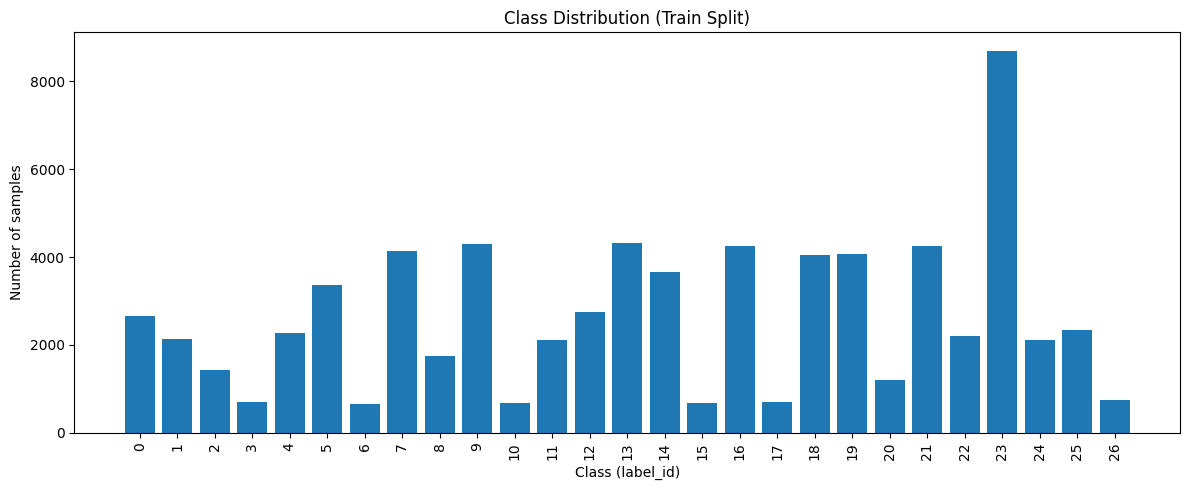

Saved: /content/results/fig_class_distribution.png


In [52]:
import os
import matplotlib.pyplot as plt
import pandas as pd

if "train_df2" in globals():
    df_for_eda = train_df2.copy()
else:
    df_for_eda = pd.read_csv("/content/train_split.csv")

os.makedirs("/content/results", exist_ok=True)


counts = df_for_eda["label_id"].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution (Train Split)")
plt.xlabel("Class (label_id)")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.tight_layout()

out_path = "/content/results/fig_class_distribution.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


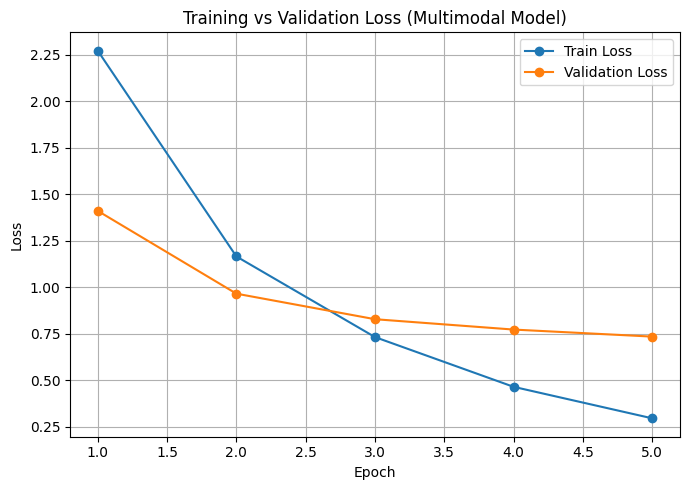

Saved: /content/results/fig_loss_curve_multimodal.png


In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs("/content/results", exist_ok=True)

# Convert history to DataFrame
hist_df = pd.DataFrame(mm_history)

plt.figure(figsize=(7, 5))
plt.plot(hist_df["epoch"], hist_df["train_loss"], marker="o", label="Train Loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Multimodal Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()

out_path = "/content/results/fig_loss_curve_multimodal.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


        Model  Val Accuracy  Val Macro-F1
0  Image-only         0.513      0.441254
1   Text-only         0.758      0.711324
2  Multimodal         0.804      0.756493


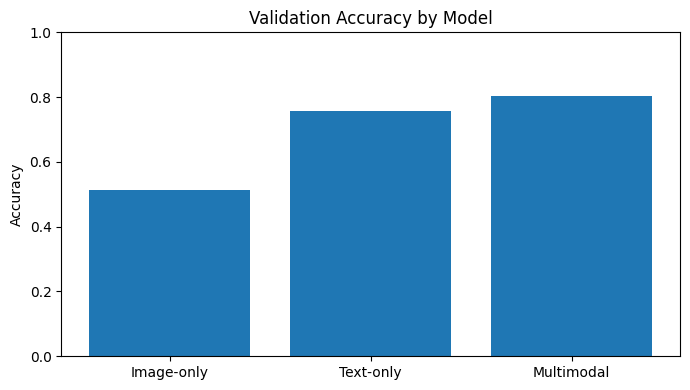

Saved: /content/results/fig_val_accuracy_comparison.png


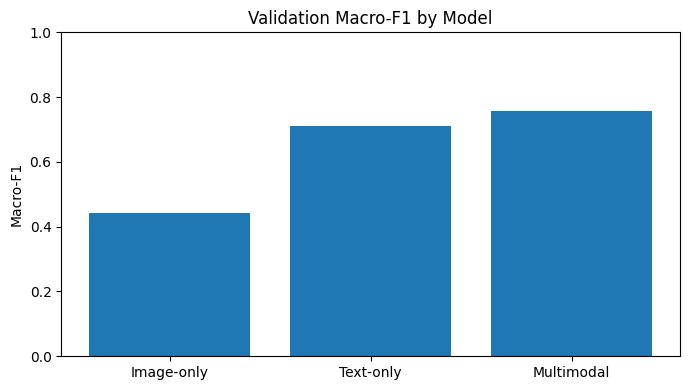

Saved: /content/results/fig_val_macro_f1_comparison.png


In [54]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

base = "/content/results"

def load_metrics(path):
    with open(path, "r") as f:
        return json.load(f)

m_img = load_metrics(os.path.join(base, "metrics_image_only.json"))
m_txt = load_metrics(os.path.join(base, "metrics_text_only.json"))
m_mm  = load_metrics(os.path.join(base, "metrics_multimodal_concat.json"))

rows = [
    {"Model": "Image-only", "Val Accuracy": m_img["val_accuracy"], "Val Macro-F1": m_img["val_f1_macro"]},
    {"Model": "Text-only", "Val Accuracy": m_txt["val_accuracy"], "Val Macro-F1": m_txt["val_f1_macro"]},
    {"Model": "Multimodal", "Val Accuracy": m_mm["val_accuracy"], "Val Macro-F1": m_mm["val_f1_macro"]},
]

df = pd.DataFrame(rows)
print(df)

# Plot Accuracy
plt.figure(figsize=(7, 4))
plt.bar(df["Model"], df["Val Accuracy"])
plt.title("Validation Accuracy by Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
acc_path = os.path.join(base, "fig_val_accuracy_comparison.png")
plt.savefig(acc_path, dpi=200)
plt.show()
print("Saved:", acc_path)

# Plot Macro-F1
plt.figure(figsize=(7, 4))
plt.bar(df["Model"], df["Val Macro-F1"])
plt.title("Validation Macro-F1 by Model")
plt.ylabel("Macro-F1")
plt.ylim(0, 1)
plt.tight_layout()
f1_path = os.path.join(base, "fig_val_macro_f1_comparison.png")
plt.savefig(f1_path, dpi=200)
plt.show()
print("Saved:", f1_path)
